Optimal Case (Index 392107) with M = 32:
  T1 = 0.893, T2 = 0.153
  Stopband max = -40.00 dB


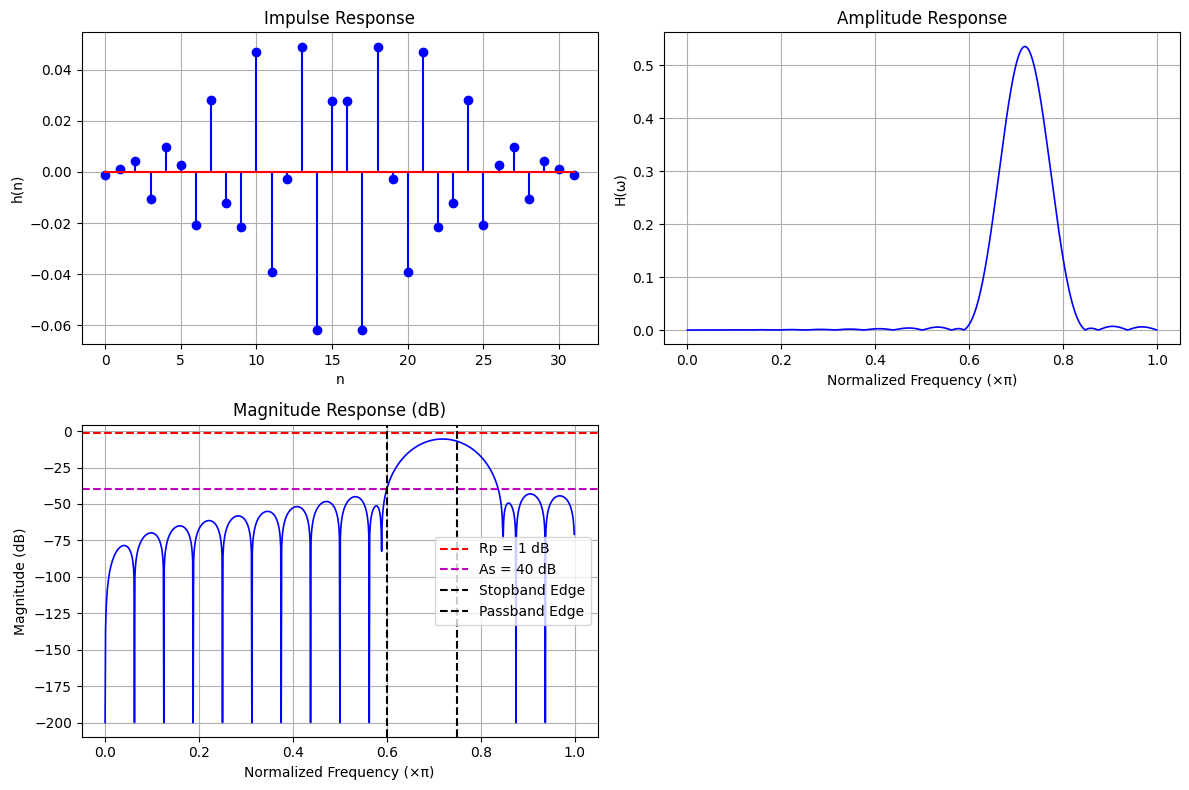

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz

# Filter specifications
M = 32  # Filter order
wp = 0.75 * np.pi  # Passband edge frequency
ws = 0.6 * np.pi  # Stopband edge frequency
Rp = 1  # Passband ripple in dB
As_target = 40  # Desired stopband attenuation in dB
alpha = (M - 1) / 2  # Symmetry parameter
l = np.arange(M)  # Sample indices
wl = (2 * np.pi / M) * l  # Frequency samples
kp = int(np.floor((M * ws) / (2 * np.pi)))  # Stopband edge index
ks = int(np.floor((M * wp) / (2 * np.pi)))  # Passband start index

# Define search space for transition band values (T1, T2)
T1_values = np.linspace(0, 1, 2000)
T2_values = np.linspace(0, 1, 2000)

# Initialize optimal tracking variables
best_stopband_max = -np.inf
best_case = {
    'T1': None,
    'T2': None,
    'Hrs': None,
    'h': None,
    'w': None,
    'Hr': None,
    'db': None,
    'index': None
}
case_index = 1

# Perform grid search over T1 and T2
for T1 in T1_values:
    for T2 in T2_values:
        # Ensure T1 > T2 and construct amplitude response for high-pass
        if T1 <= T2:
            continue
        
        Hrs = np.zeros(M)
        Hrs[:kp+1] = 0  # Stopband
        Hrs[kp+1] = T2  # Transition band (T2)
        Hrs[kp+2] = T1  # Transition band (T1)
        Hrs[kp+3:ks] = 1  # Passband
        Hrs[ks] = T1  # Transition band (T1)
        Hrs[ks+1] = T2  # Transition band (T2)
        Hrs[ks+2:] = 0  # Stopband
        
        # Validate length
        if len(Hrs) != M:
            raise ValueError(f"Hrs must have length {M}, but got {len(Hrs)}")
        
        # Construct the filter's frequency response
        k1 = np.arange(0, int((M - 1) / 2) + 1)
        k2 = np.arange(int((M - 1) / 2) + 1, M)
        phase_shift = np.concatenate([
            -alpha * (2 * np.pi / M) * k1,
            alpha * (2 * np.pi / M) * (M - k2)
        ])
        H = Hrs * np.exp(1j * phase_shift)
        h = np.real(np.fft.ifft(H, M))
        
        # Compute frequency response
        w, H_freqz = freqz(h, worN=1024)
        db_response = 20 * np.log10(np.maximum(np.abs(H_freqz), 1e-10))
        Hr_magnitude = np.abs(H_freqz)
        
        # Evaluate stopband performance (frequencies where w <= ws)
        stopband_indices = np.where(w <= ws)[0]
        stopband_max_dB = np.max(db_response[stopband_indices])
        
        # If stopband max is <= -As_target, check for best case
        if stopband_max_dB <= -As_target and stopband_max_dB > best_stopband_max:
            best_stopband_max = stopband_max_dB
            best_case['T1'] = T1
            best_case['T2'] = T2
            best_case['Hrs'] = Hrs
            best_case['h'] = h
            best_case['w'] = w
            best_case['Hr'] = Hr_magnitude
            best_case['db'] = db_response
            best_case['index'] = case_index
        
        case_index += 1

# Display best case
if best_case['index'] is None:
    print("No valid transition values (T1, T2) found that satisfy attenuation criteria.")
else:
    print(f"Optimal Case (Index {best_case['index']}) with M = {M}:")
    print(f"  T1 = {best_case['T1']:.3f}, T2 = {best_case['T2']:.3f}")
    print(f"  Stopband max = {best_stopband_max:.2f} dB")
    
    # Plot results
    plt.figure(figsize=(12, 8))
    
    # Impulse Response
    plt.subplot(2, 2, 1)
    plt.stem(l, best_case['h'], linefmt='b-', markerfmt='bo', basefmt='r-')
    plt.title("Impulse Response")
    plt.xlabel("n")
    plt.ylabel("h(n)")
    plt.grid(True)
    
    # Amplitude Response
    plt.subplot(2, 2, 2)
    plt.plot(best_case['w'] / np.pi, best_case['Hr'], 'b-', linewidth=1.2)
    plt.title("Amplitude Response")
    plt.xlabel("Normalized Frequency (×π)")
    plt.ylabel("H(ω)")
    plt.grid(True)
    
    # Magnitude Response in dB
    plt.subplot(2, 2, 3)
    plt.plot(best_case['w'] / np.pi, best_case['db'], 'b-', linewidth=1.2)
    plt.axhline(-Rp, color='r', linestyle='--', label=f"Rp = {Rp} dB")
    plt.axhline(-As_target, color='m', linestyle='--', label=f"As = {As_target} dB")
    plt.axvline(ws / np.pi, color='k', linestyle='--', label="Stopband Edge")
    plt.axvline(wp / np.pi, color='k', linestyle='--', label="Passband Edge")
    plt.title("Magnitude Response (dB)")
    plt.xlabel("Normalized Frequency (×π)")
    plt.ylabel("Magnitude (dB)")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()